## VAE Hawkes Process Estimation - Tutorial

In [1]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
from dl.vae_model import VAETrainer
from dl.dueling_decoder import DuelingTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors, integrate_intensity
from hawkes.simulation import hawkes_simulations, MLE
from hawkes.discretisation import discretise
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import read_parquet, timer
from visualization.error_viz import convergence_rate, errors_boxplots, effects_boxplots, reconstruction_plot
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

### Preprocessing

In [151]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="vae/hawkes_hyperparams.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="vae/hawkes_simulations.parquet")

# Discretized hawkes process
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="vae/binned_hawkes_simulations.parquet")

### Training

In [2]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("dueling_decoder/binned_hawkes_simulations.parquet")
y = read_parquet("dueling_decoder/hawkes_hyperparams.parquet")

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']]) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [ ]:
!python3 -m pip install pystan

In [3]:
# Trained models

# model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
model, train_losses, val_losses, val_x_pred = VAETrainer().train_model(train_loader, val_loader, val_x, val_y)
# model, train_losses, val_losses, val_x_pred = DuelingTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
PoissonVAE                               [10000, 100]              [10000, 100]              --                             --                   --                        --                        True
├─Sequential: 1-1                        [10000, 100]              [10000, 37]               --                             --                   --                        --                        True
│    └─Linear: 2-1                       [10000, 100]              [10000, 75]               7,575                      33.56%                   --                        75,750,000                True
│    └─ReLU: 2-2                         [10000, 75]               [10000, 75]               --                             --                   --                        --              

Epoch 2287/10000 - train_loss: -312.8148, val_loss: -329.9386, annealing: 0.0715:  23%|██▎       | 2287/10000 [4:42:42<15:02:59,  7.02s/it]

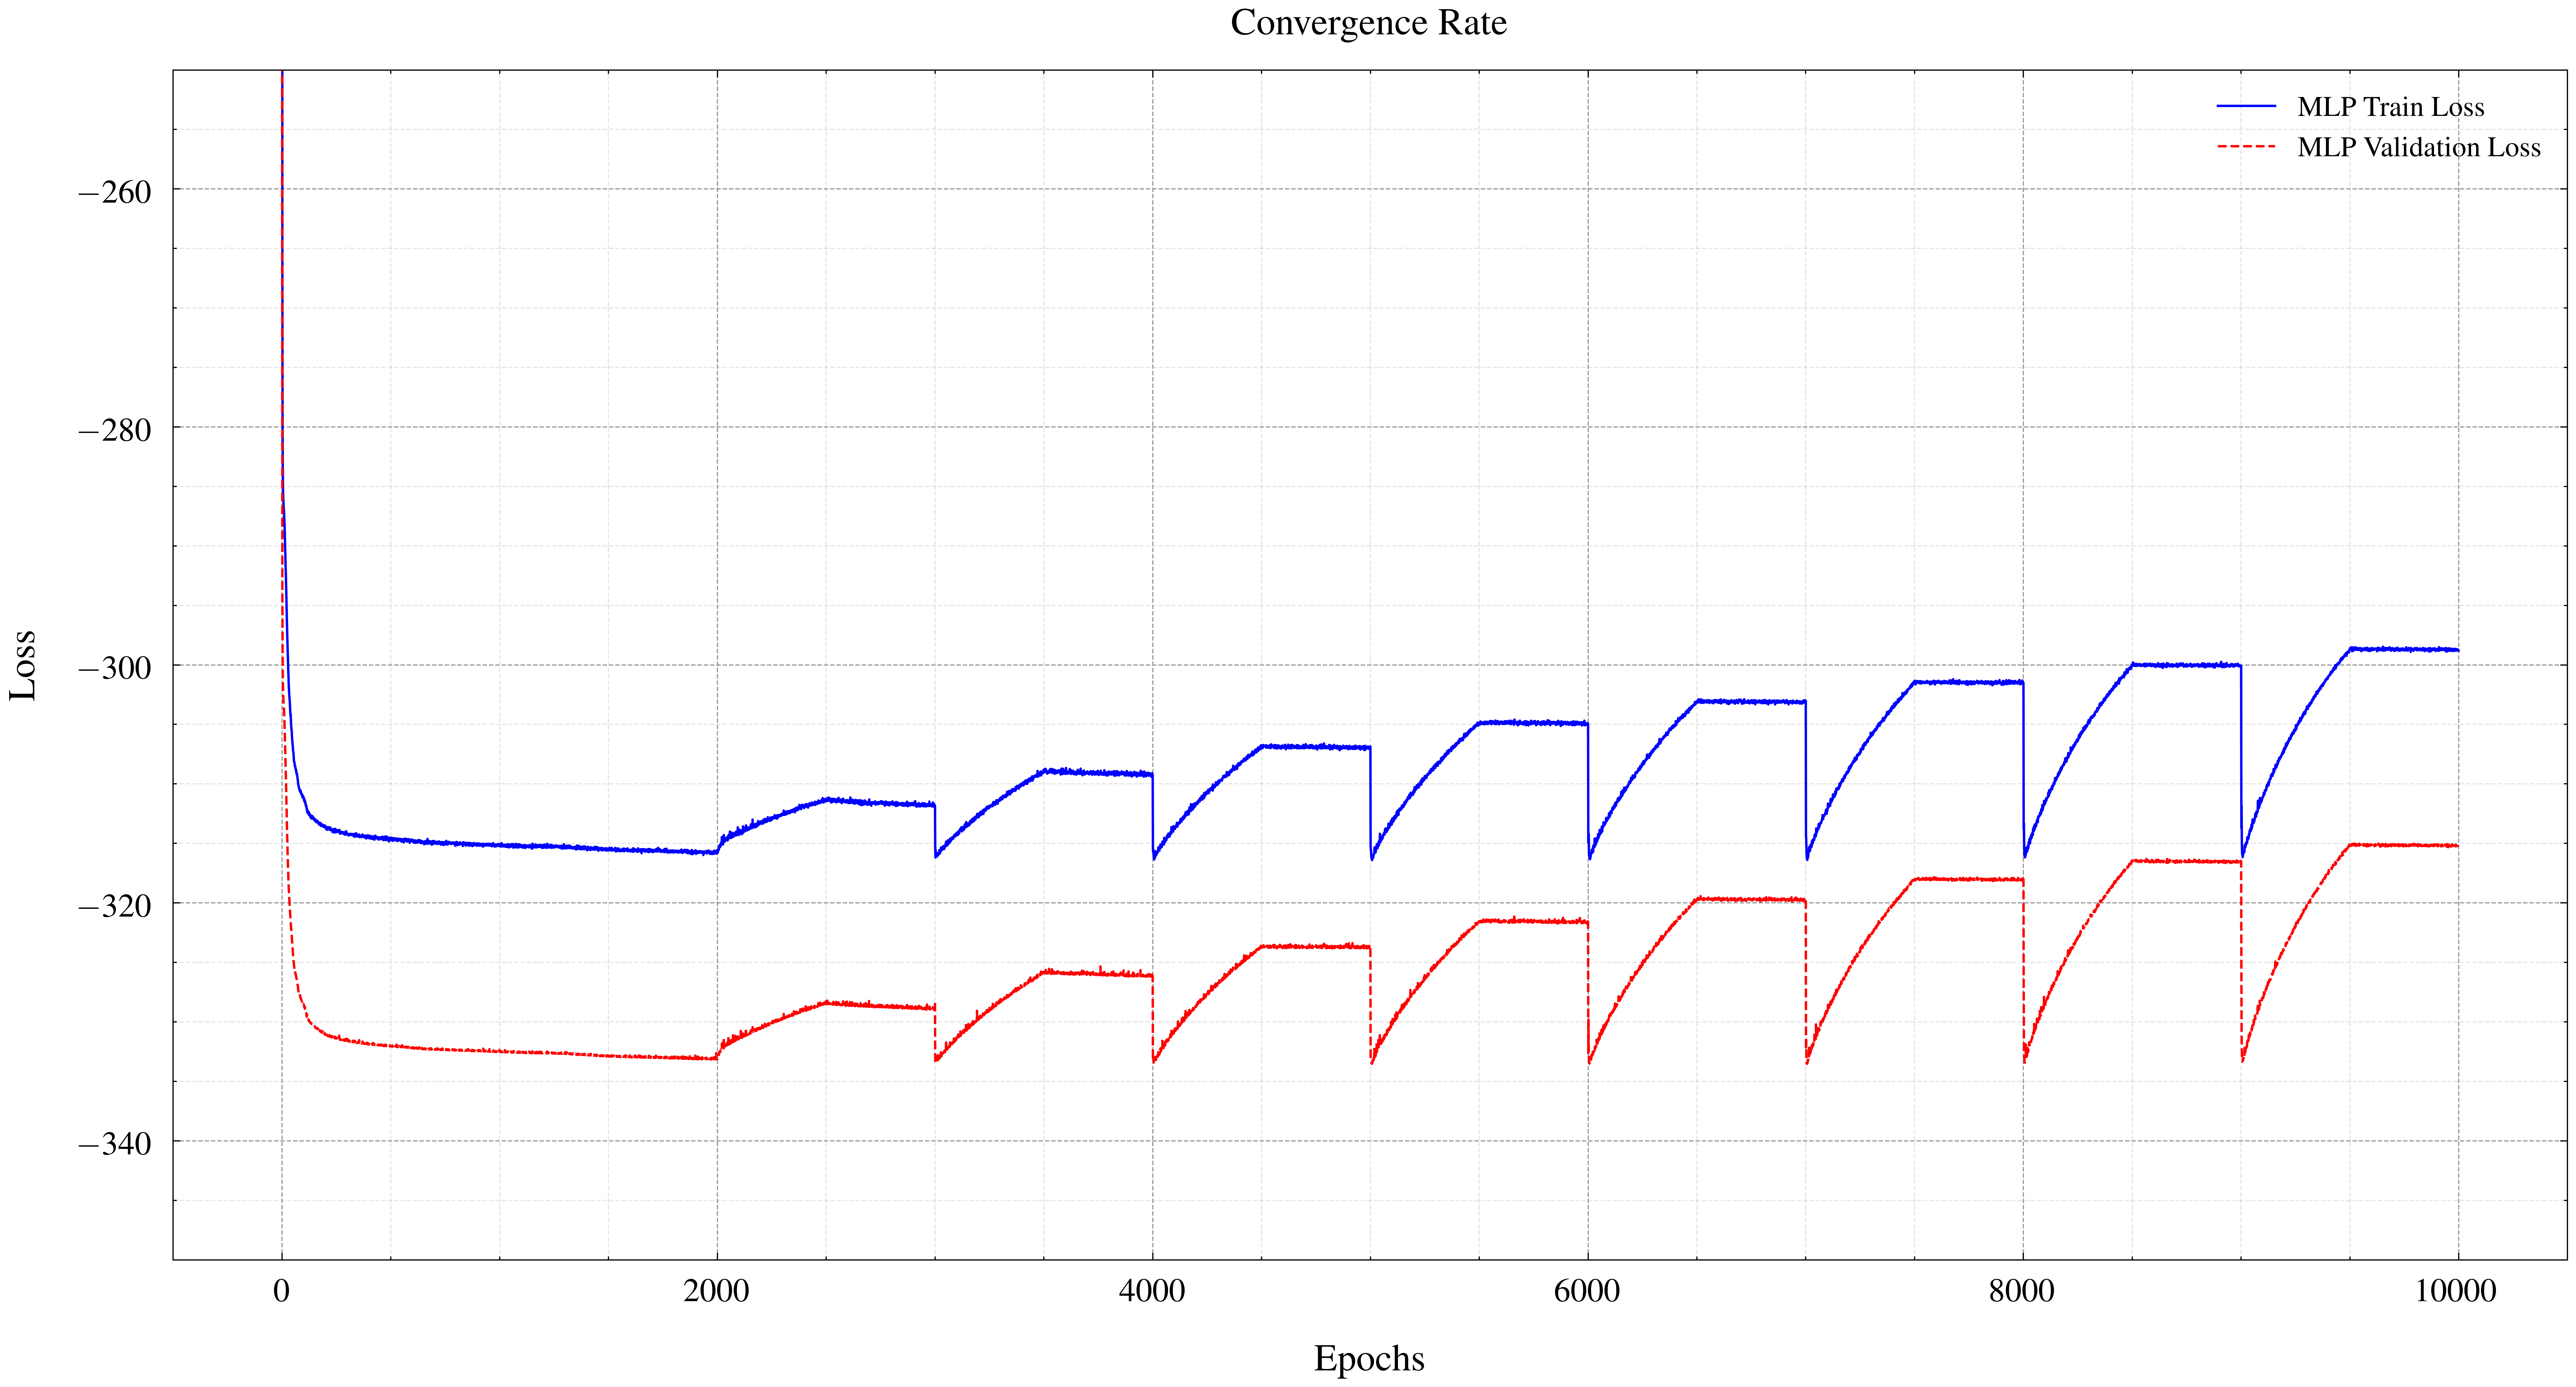

In [27]:
# Convergence rate plots

# bench_losses = read_parquet('benchmark/losses_benchmark.parquet')
# mlp_losses = read_parquet('br_mlp/losses_mlp_br_0.05_0.8.parquet')
vae_losses = read_parquet('vae/losses_vae.parquet')
# dd_losses = read_parquet('vae/losses_dueling_decoder.parquet')

convergence_rate(losses=[vae_losses], models=["VAE"], colors=["blue", "red"])

### Testing

In [31]:
# Tested models (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

# x = read_parquet("br_mlp/binned_hawkes_simulations_br_0.05_0.8.parquet")
# y = read_parquet("br_mlp/hawkes_hyperparams_br_0.05_0.8.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
# test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)

x = read_parquet("vae/binned_hawkes_simulations_beta_1_eta_0.2.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_3_eta_0.2.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_1_eta_0.7.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_3_eta_0.7.parquet")

test_x, test_y, _, _, _, _ = split_data(x, x) 
intensity_pred = VAETrainer().test_model(test_x, test_y)

# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_1_eta_0.2.parquet")
# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_3_eta_0.2.parquet")
# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_1_eta_0.7.parquet")
# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_3_eta_0.7.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']]) 
# x_pred = DuelingTrainer().test_model(test_x, test_y)

%load_ext tensorboard

Best model loading (2023_06_27_16_31_33_MICSHPEG8GIRARD_best_model.pt)...
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [98]:
# Computed NRMSE error + reconstruction plots

beta_1_br_02_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_1_eta_0.2.parquet')
beta_1_br_02_simulations = read_parquet('vae/hawkes_simulations_beta_1_eta_0.2.parquet')
beta_1_br_02_pred = read_parquet('vae/predictions_beta_1_eta_0.2.parquet')

beta_3_br_02_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_3_eta_0.2.parquet')
beta_3_br_02_simulations = read_parquet('vae/hawkes_simulations_beta_3_eta_0.2.parquet')
beta_3_br_02_pred = read_parquet('vae/predictions_beta_3_eta_0.2.parquet')

beta_1_br_07_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_1_eta_0.7.parquet')
beta_1_br_07_simulations = read_parquet('vae/hawkes_simulations_beta_1_eta_0.7.parquet')
beta_1_br_07_pred = read_parquet('vae/predictions_beta_1_eta_0.7.parquet')

beta_3_br_07_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_3_eta_0.7.parquet')
beta_3_br_07_simulations = read_parquet('vae/hawkes_simulations_beta_3_eta_0.7.parquet')
beta_3_br_07_pred = read_parquet('vae/predictions_beta_3_eta_0.7.parquet')

beta_1_br_02_errors = integrate_intensity(beta_1_br_02_hyperparams, beta_1_br_02_simulations, beta_1_br_02_pred['intensities_pred'], filename="vae/intensity_error_beta_1_eta_0.2.parquet")
beta_3_br_02_errors = integrate_intensity(beta_3_br_02_hyperparams, beta_3_br_02_simulations, beta_3_br_02_pred['intensities_pred'], filename="vae/intensity_error_beta_3_eta_0.2.parquet")
beta_1_br_07_errors = integrate_intensity(beta_1_br_07_hyperparams, beta_1_br_07_simulations, beta_1_br_07_pred['intensities_pred'], filename="vae/intensity_error_beta_1_eta_0.7.parquet")
beta_3_br_07_errors = integrate_intensity(beta_3_br_07_hyperparams, beta_3_br_07_simulations, beta_3_br_07_pred['intensities_pred'], filename="vae/intensity_error_beta_3_eta_0.7.parquet")

reconstruction_plot(decoded_intensities=[beta_1_br_02_errors['decoded_intensity'], beta_3_br_02_errors['decoded_intensity'], beta_1_br_07_errors['decoded_intensity'], beta_3_br_07_errors['decoded_intensity']], 
                    integrated_intensities=[beta_1_br_02_errors['integrated_intensity'], beta_3_br_02_errors['integrated_intensity'], beta_1_br_07_errors['integrated_intensity'], beta_3_br_07_errors['integrated_intensity']])

In [ ]:
# Computed NRMSE error + reconstruction plots + density plots

beta_1_br_02_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_1_eta_0.2.parquet')
beta_1_br_02_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_1_eta_0.2.parquet')
beta_1_br_02_pred = read_parquet('dueling_decoder/predictions_beta_1_eta_0.2.parquet')

beta_3_br_02_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_3_eta_0.2.parquet')
beta_3_br_02_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_3_eta_0.2.parquet')
beta_3_br_02_pred = read_parquet('dueling_decoder/predictions_beta_3_eta_0.2.parquet')

beta_1_br_07_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_1_eta_0.7.parquet')
beta_1_br_07_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_1_eta_0.7.parquet')
beta_1_br_07_pred = read_parquet('dueling_decoder/predictions_beta_1_eta_0.7.parquet')

beta_3_br_07_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_3_eta_0.7.parquet')
beta_3_br_07_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_3_eta_0.7.parquet')
beta_3_br_07_pred = read_parquet('dueling_decoder/predictions_beta_3_eta_0.7.parquet')

beta_1_br_02_errors = integrate_intensity(beta_1_br_02_hyperparams, beta_1_br_02_simulations, beta_1_br_02_pred['intensities_pred'], filename="dueling_decoder/intensity_error_beta_1_eta_0.2.parquet")
beta_3_br_02_errors = integrate_intensity(beta_3_br_02_hyperparams, beta_3_br_02_simulations, beta_3_br_02_pred['intensities_pred'], filename="dueling_decoder/intensity_error_beta_3_eta_0.2.parquet")
beta_1_br_07_errors = integrate_intensity(beta_1_br_07_hyperparams, beta_1_br_07_simulations, beta_1_br_07_pred['intensities_pred'], filename="dueling_decoder/intensity_error_beta_1_eta_0.7.parquet")
beta_3_br_07_errors = integrate_intensity(beta_3_br_07_hyperparams, beta_3_br_07_simulations, beta_3_br_07_pred['intensities_pred'], filename="dueling_decoder/intensity_error_beta_3_eta_0.7.parquet")

reconstruction_plot(decoded_intensities=[beta_1_br_02_errors['decoded_intensity'], beta_3_br_02_errors['decoded_intensity'], beta_1_br_07_errors['decoded_intensity'], beta_3_br_07_errors['decoded_intensity']], 
                    integrated_intensities=[beta_1_br_02_errors['integrated_intensity'], beta_3_br_02_errors['integrated_intensity'], beta_1_br_07_errors['integrated_intensity'], beta_3_br_07_errors['integrated_intensity']])